In [1]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='alpaca_data_1.json', split='train')
eval_dataset = load_dataset('json', data_files='alpaca_data_1.json', split='train')

In [2]:
train_dataset[0]

{'output': 'neutral',
 'instruction': 'Predict the impact of the event.',
 'input': 'OTTAWA, ON, Nov. 2, 2022 /CNW/ - Hurricane Fiona has had a devastating effect on communities across Atlantic Canada and Eastern Quebec. Houses and buildings have been severely damaged and destroyed, as well as small craft harbours that are critical to fisheries and coastal communities.'}

### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

def formatting_func(example):
    text = f"### Question: {example['input'] + ' ' +example['input']}\n ### Answer: {example['output']}"
    return text

def formatting_func(example):
    text = f"input: {example['input'] }\n output: {example['output']}"
    return text

formatting_func(train_dataset[0])

def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text

In [3]:
#Here's another common one:
def formatting_func(example):
    text = f"### Question: {example['instruction']+' : '+example['input']}\n ### Answer: {example['output']}"
    return text

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [6]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

2008


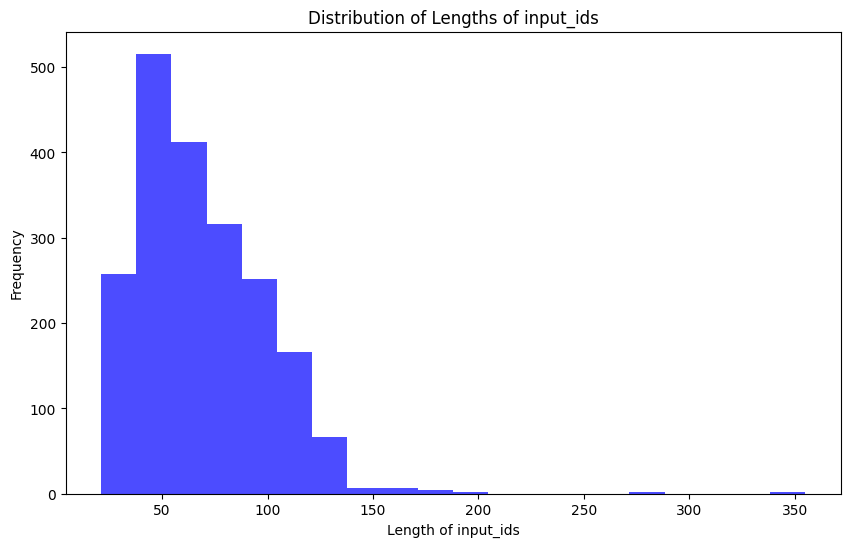

In [7]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [8]:
max_length = 200 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [10]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 22478, 28747, 19122, 848, 272, 5088, 302, 272, 1951, 28723, 714, 320, 1017, 832, 3957, 28725, 8515, 28723, 28705, 28734, 28750, 28725, 28705, 28750, 28734, 28750, 28750, 325, 420, 1763, 7657, 9991, 7965, 14745, 896, 1143, 1939, 9063, 9132, 5196, 643, 5671, 28723, 325, 345, 4738, 28765, 28739, 442, 272, 345, 24673, 28739, 1143, 325, 334, 1151, 28747, 365, 7065, 28759, 1143, 1200, 264, 5374, 3964, 2556, 2724, 9132, 4099, 5799, 28725, 349, 12846, 298, 12411, 369, 272, 6452, 659, 7365, 264, 1480, 1745, 302, 272, 14887, 6924, 302, 4409, 14402, 2151, 3844, 272, 3850, 13, 774, 26307, 28747, 14214, 2]


Now all the samples should be the same length, `max_length`.

2008


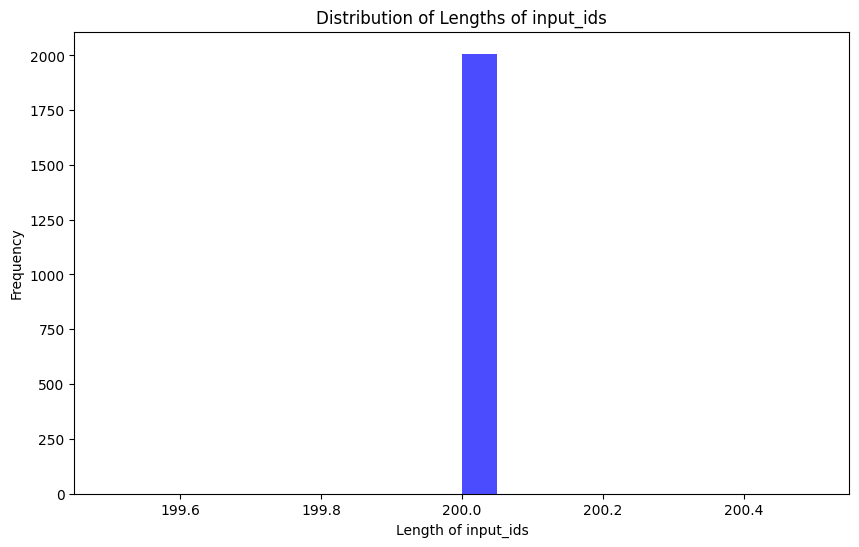

In [11]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

The `eval_prompt` I used was:

In [13]:
eval_prompt = " OTTAWA, ON, Nov. 2, 2022 /CNW/ - Hurricane Fiona has had a devastating effect on communities across Atlantic Canada and Eastern Quebec. Houses and buildings have been severely damaged and destroyed, as well as small craft harbours that are critical to fisheries and coastal communities."

In [14]:
# Re-init the tokenizer so it doesn't add padding or eos token
# tokenizer = AutoTokenizer.from_pretrained(
#     base_model_id,
#     add_bos_token=True,
# )


tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 OTTAWA, ON, Nov. 2, 2022 /CNW/ - Hurricane Fiona has had a devastating effect on communities across Atlantic Canada and Eastern Quebec. Houses and buildings have been severely damaged and destroyed, as well as small craft harbours that are critical to fisheries and coastal communities.кiпeпs in the region are working hard to recover from this disaster and rebuild their lives.

The Government of Canada is committed to helping those affected by natural disasters get back on their feet. That's why today, the Honourable Ginette Petitpas Taylor, Minister of Health, announced funding for the Canadian Red Cross to support people who need help with immediate needs such as food, clothing, shelter, and other essential items. This funding will also help people access mental health services and supports.

This funding is part of the Disaster Financial Assistance Arrangements (DFAA), which provides financial assistance to provinces and territories when they experience an extraordinary event beyond

Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [17]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [19]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(

### Accelerator

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [20]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [21]:
model = accelerator.prepare_model(model)


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [22]:
# !pip install -q wandb -U

# import wandb, os
# wandb.login()

# wandb_project = "journal-finetune"
# if len(wandb_project) > 0:
#     os.environ["WANDB_PROJECT"] = wandb_project

### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [23]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [24]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=10,
        gradient_accumulation_steps=1,
        max_steps=100,
        learning_rate=2.5e-5, # Want a small lr for finetuning
       # bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        #report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this 

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/winemocol/anaconda3/envs/llm/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.835000,1.343403
50,1.375600,1.242300
75,1.267700,1.303463
100,1.336000,1.255558


/home/winemocol/anaconda3/envs/llm/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/winemocol/anaconda3/envs/llm/lib/python3.9/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/winemocol/anaconda3/envs/llm/lib/pytho

TrainOutput(global_step=100, training_loss=1.453576545715332, metrics={'train_runtime': 3267.1805, 'train_samples_per_second': 0.306, 'train_steps_per_second': 0.031, 'total_flos': 8634841497600000.0, 'train_loss': 1.453576545715332, 'epoch': 0.99})

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`). 

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
   # use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-journal-finetune/checkpoint-100")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [2]:
eval_prompt = " Please identify if the following event is associated with opportunity or risk, select from the following labels: risk, minor risk, neutral, minor opportunity, opportunity. In the response, please only show the predicted label. Here is the event: OTTAWA, ON, Nov. 2, 2022 /CNW/ - Hurricane Fiona has had a devastating effect on communities across Atlantic Canada and Eastern Quebec. Houses and buildings have been severely damaged and destroyed, as well as small craft harbours that are critical to fisheries and coastal communities."

In [ ]:
#eval_prompt = " The following is a note by Eevee the Dog, which doesn't share anything too personal: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))